# 2 layers model

#### Gathering of all functions needed to train a model:

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import keras
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
import numpy as np
from keras.models import load_model
from numpy import argmax

def read_csv(filename):
    dataset = pd.read_csv(filename, encoding='utf-8')
    return dataset

def one_hot_encode(dataset):
    dataset_one_hot_encoded = pd.get_dummies(dataset)  
    return dataset_one_hot_encoded

def divide_X_y(dataset, index_sep):
    X = dataset.iloc[:,:index_sep]
    y = dataset.iloc[:,index_sep:]
    return X,y

def split_train_test(X, y, test_size):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1)
    return X_train, X_test, y_train, y_test
    
def graph_loss_vs_epochs(history, save_image_filename, title):
    training_loss = history.history['loss']
    test_loss = history.history['val_loss']
    epoch_count = range(1, len(training_loss) + 1)
    plt.title(title)
    plt.plot(epoch_count, training_loss, 'r--')
    plt.plot(epoch_count, test_loss, 'b-')
    plt.legend(['Training Loss', 'Test Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss') 
    plt.axvline(x = epoch_count[test_loss.index(min(test_loss))], color = 'c', linestyle="dotted")
    plt.savefig(save_image_filename)
    plt.show()
    
def save_history(filename, model):
    # ejemplo de filename:'history1.npy'
    np.save(filename,model.history.history)
    
def load_history(filename):
    history=np.load(filename,allow_pickle='TRUE').item()
    return history

def evaluate_model(model, X_test, y_test):
    print('\nEvaluating:')
    (test_loss, test_accuracy) = model.evaluate(X_test, y_test)
    print(f'\nTest accuracy: {test_accuracy * 100:>0.1f}%, test loss: {test_loss:>8f}')
    
def get_label(column):
    label = y_test.columns[column]
    return label.replace('Nivel de Adaptación_', '')

def fill_test_ds_labels(model, test_ds_filename, output_test_filename):
    test_ds = read_csv(test_ds_filename)
    test_ds = pd.get_dummies(test_ds)
    nivel_de_adaptacion_test_ds = []
    for index,test in test_ds.iterrows():
        test_ds_pred = pd.DataFrame(test).transpose()
        test_oh = pd.get_dummies(test_ds_pred)
        prediction = model.predict(test_oh)
        nivel_de_adaptacion_test_ds.append((index+1,get_label(argmax(prediction))))
    print(len(nivel_de_adaptacion_test_ds))
    nivel_de_adaptacion_df = pd.DataFrame(nivel_de_adaptacion_test_ds, columns=['id','Nivel de Adaptación']).reset_index(drop=True)
    nivel_de_adaptacion_df.to_csv(output_test_filename,index=False)

##### Loading, preparing and dividing dataset for Experiments:

In [39]:
index_sep = 31
test_size=0.2
dataset = read_csv('../training-ds.csv')
dataset = one_hot_encode(dataset)
X, y = divide_X_y(dataset, index_sep)
X_train, X_test, y_train, y_test = split_train_test(X, y, test_size)

##### Model_2 v1
    2 layers
    learning_rate = 0.01
    batch_size = 64
    optimizer: ADAM
    Dense units:  10, 10

In [28]:
model = tf.keras.Sequential([      
      tf.keras.layers.Dense(10, activation='relu'),
      tf.keras.layers.Dense(10, activation='relu'),
      tf.keras.layers.Dense(3)
    ])

Epoch 1/4000
13/13 - 2s - loss: 1.0330 - accuracy: 0.4475 - val_loss: 0.8861 - val_accuracy: 0.5751

Epoch 00001: val_loss improved from inf to 0.88605, saving model to models\model_2L_v1
INFO:tensorflow:Assets written to: models\model_2L_v1\assets
Epoch 2/4000
13/13 - 0s - loss: 0.8801 - accuracy: 0.5668 - val_loss: 0.8413 - val_accuracy: 0.6580

Epoch 00002: val_loss improved from 0.88605 to 0.84131, saving model to models\model_2L_v1
INFO:tensorflow:Assets written to: models\model_2L_v1\assets
Epoch 3/4000
13/13 - 0s - loss: 0.8341 - accuracy: 0.6083 - val_loss: 0.7738 - val_accuracy: 0.6580

Epoch 00003: val_loss improved from 0.84131 to 0.77379, saving model to models\model_2L_v1
INFO:tensorflow:Assets written to: models\model_2L_v1\assets
Epoch 4/4000
13/13 - 0s - loss: 0.7847 - accuracy: 0.6446 - val_loss: 0.7580 - val_accuracy: 0.6684

Epoch 00004: val_loss improved from 0.77379 to 0.75801, saving model to models\model_2L_v1
INFO:tensorflow:Assets written to: models\model_2L_v1

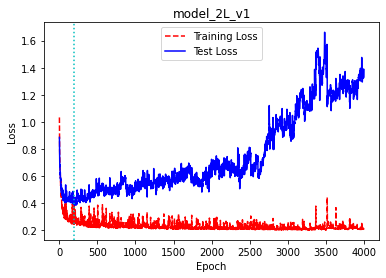

In [29]:
learning_rate = 0.01
batch_size = 64
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate)
metrics = ['accuracy']
model_filename = 'models/model_2L_v1'
model_l_v_e_filename = 'loss_vs_epochs_images/model_2L_v1_le.png'
model_l_v_e_title = 'model_2L_v1'
model_history_filename = 'history/history_model_2L_v1'

model.compile(optimizer, loss_fn, metrics)


checkpoint = ModelCheckpoint(model_filename, monitor='val_loss', verbose=1,save_best_only=True, mode='min')
model.fit(X_train, y_train, epochs = 4000,  validation_data=(X_test, y_test),batch_size = batch_size,callbacks=[checkpoint], verbose=2)
model.summary()
graph_loss_vs_epochs(model.history, model_l_v_e_filename, model_l_v_e_title)
save_history(model_history_filename, model)

In [30]:
best_m1_v1 = load_model(model_filename)
evaluate_model(best_m1_v1, X_test, y_test)


Evaluating:
7/7 [==============================] - 1s 2ms/step - loss: 0.3861 - accuracy: 0.8342

Test accuracy: 83.4%, test loss: 0.386146


In [31]:
test_ds_filename = '../test-ds.csv'
output_filename_test_ds_labeled = 'test-ds-m2L_v1.csv'
fill_test_ds_labels(model, test_ds_filename, output_filename_test_ds_labeled)

241


##### Model_2 v2
    2 layers
    learning_rate = 0.005
    batch_size = 64
    optimizer: ADAM
    Dense units:  20, 20

In [34]:
model = tf.keras.Sequential([      
      tf.keras.layers.Dense(20, activation='relu'),
      tf.keras.layers.Dense(20, activation='relu'),
      tf.keras.layers.Dense(3)
    ])

Epoch 1/4000
13/13 - 2s - loss: 0.9551 - accuracy: 0.5435 - val_loss: 0.8595 - val_accuracy: 0.6218

Epoch 00001: val_loss improved from inf to 0.85945, saving model to models\model_2L_v2
INFO:tensorflow:Assets written to: models\model_2L_v2\assets
Epoch 2/4000
13/13 - 0s - loss: 0.8386 - accuracy: 0.6187 - val_loss: 0.8256 - val_accuracy: 0.6788

Epoch 00002: val_loss improved from 0.85945 to 0.82556, saving model to models\model_2L_v2
INFO:tensorflow:Assets written to: models\model_2L_v2\assets
Epoch 3/4000
13/13 - 0s - loss: 0.7819 - accuracy: 0.6641 - val_loss: 0.7378 - val_accuracy: 0.6632

Epoch 00003: val_loss improved from 0.82556 to 0.73782, saving model to models\model_2L_v2
INFO:tensorflow:Assets written to: models\model_2L_v2\assets
Epoch 4/4000
13/13 - 0s - loss: 0.7399 - accuracy: 0.6732 - val_loss: 0.7118 - val_accuracy: 0.6839

Epoch 00004: val_loss improved from 0.73782 to 0.71180, saving model to models\model_2L_v2
INFO:tensorflow:Assets written to: models\model_2L_v2

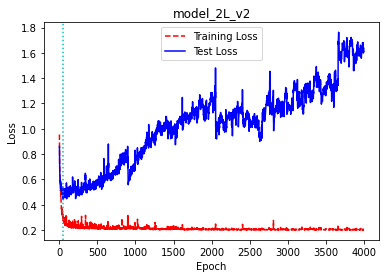

In [35]:
learning_rate = 0.005
batch_size = 64
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate)
metrics = ['accuracy']
model_filename = 'models/model_2L_v2'
model_l_v_e_filename = 'loss_vs_epochs_images/model_2L_v2_le.png'
model_l_v_e_title = 'model_2L_v2'
model_history_filename = 'history/history_model_2L_v2'

model.compile(optimizer, loss_fn, metrics)


checkpoint = ModelCheckpoint(model_filename, monitor='val_loss', verbose=1,save_best_only=True, mode='min')
model.fit(X_train, y_train, epochs = 4000,  validation_data=(X_test, y_test),batch_size = batch_size,callbacks=[checkpoint], verbose=2)
model.summary()
graph_loss_vs_epochs(model.history, model_l_v_e_filename, model_l_v_e_title)
save_history(model_history_filename, model)

In [36]:
best_m1_v2 = load_model(model_filename)
evaluate_model(best_m1_v2, X_test, y_test)


Evaluating:
7/7 [==============================] - 1s 3ms/step - loss: 0.4410 - accuracy: 0.8135

Test accuracy: 81.3%, test loss: 0.441027


In [37]:
output_filename_test_ds_labeled = 'test-ds-m2L_v2.csv'
fill_test_ds_labels(model, test_ds_filename, output_filename_test_ds_labeled)

241


   ##### Model_2 v3
    2 layers
    learning_rate = 0.001
    batch_size = 64
    optimizer: ADAM
    Dense units:  10, 20

In [40]:
model = tf.keras.Sequential([      
      tf.keras.layers.Dense(10, activation='relu'),
      tf.keras.layers.Dense(20, activation='relu'),
      tf.keras.layers.Dense(3)
    ])

Epoch 1/4000
13/13 - 1s - loss: 1.0943 - accuracy: 0.5084 - val_loss: 1.0299 - val_accuracy: 0.5699

Epoch 00001: val_loss improved from inf to 1.02994, saving model to models\model_2L_v3
INFO:tensorflow:Assets written to: models\model_2L_v3\assets
Epoch 2/4000
13/13 - 0s - loss: 1.0485 - accuracy: 0.5084 - val_loss: 0.9970 - val_accuracy: 0.5751

Epoch 00002: val_loss improved from 1.02994 to 0.99698, saving model to models\model_2L_v3
INFO:tensorflow:Assets written to: models\model_2L_v3\assets
Epoch 3/4000
13/13 - 0s - loss: 1.0133 - accuracy: 0.5123 - val_loss: 0.9686 - val_accuracy: 0.5751

Epoch 00003: val_loss improved from 0.99698 to 0.96860, saving model to models\model_2L_v3
INFO:tensorflow:Assets written to: models\model_2L_v3\assets
Epoch 4/4000
13/13 - 0s - loss: 0.9790 - accuracy: 0.5240 - val_loss: 0.9389 - val_accuracy: 0.6010

Epoch 00004: val_loss improved from 0.96860 to 0.93894, saving model to models\model_2L_v3
INFO:tensorflow:Assets written to: models\model_2L_v3

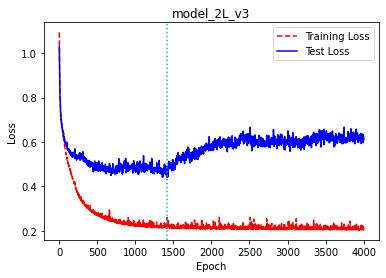

In [42]:
learning_rate = 0.001
batch_size = 64
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate)
metrics = ['accuracy']
model_filename = 'models/model_2L_v3'
model_l_v_e_filename = 'loss_vs_epochs_images/model_2L_v3_le.png'
model_l_v_e_title = 'model_2L_v3'
model_history_filename = 'history/history_model_2L_v3'

model.compile(optimizer, loss_fn, metrics)


checkpoint = ModelCheckpoint(model_filename, monitor='val_loss', verbose=1,save_best_only=True, mode='min')
model.fit(X_train, y_train, epochs = 4000,  validation_data=(X_test, y_test),batch_size = batch_size,callbacks=[checkpoint], verbose=2)
model.summary()
graph_loss_vs_epochs(model.history, model_l_v_e_filename, model_l_v_e_title)
save_history(model_history_filename, model)

In [43]:
test_ds_filename = '../test-ds.csv'
best_m1_v3 = load_model(model_filename)
evaluate_model(best_m1_v3, X_test, y_test)


Evaluating:
7/7 [==============================] - 1s 3ms/step - loss: 0.4414 - accuracy: 0.8238

Test accuracy: 82.4%, test loss: 0.441350


In [44]:
output_filename_test_ds_labeled = 'test-ds-m2L_v3.csv'
fill_test_ds_labels(model, test_ds_filename, output_filename_test_ds_labeled)

241


   ##### Model_2 v4
    2 layers
    learning_rate = 0.01
    batch_size = 32
    optimizer: ADAM
    Dense units:  128, 64

Epoch 1/3000
25/25 - 2s - loss: 0.8112 - accuracy: 0.6278 - val_loss: 0.7322 - val_accuracy: 0.7047

Epoch 00001: val_loss improved from inf to 0.73217, saving model to models\model_2L_v4
INFO:tensorflow:Assets written to: models\model_2L_v4\assets
Epoch 2/3000
25/25 - 0s - loss: 0.6721 - accuracy: 0.6939 - val_loss: 0.5523 - val_accuracy: 0.7513

Epoch 00002: val_loss improved from 0.73217 to 0.55229, saving model to models\model_2L_v4
INFO:tensorflow:Assets written to: models\model_2L_v4\assets
Epoch 3/3000
25/25 - 0s - loss: 0.5682 - accuracy: 0.7510 - val_loss: 0.6120 - val_accuracy: 0.7150

Epoch 00003: val_loss did not improve from 0.55229
Epoch 4/3000
25/25 - 0s - loss: 0.5032 - accuracy: 0.7756 - val_loss: 0.6031 - val_accuracy: 0.7306

Epoch 00004: val_loss did not improve from 0.55229
Epoch 5/3000
25/25 - 0s - loss: 0.4583 - accuracy: 0.8042 - val_loss: 0.5473 - val_accuracy: 0.7824

Epoch 00005: val_loss improved from 0.55229 to 0.54726, saving model to models\model_2L_v4
IN

FileNotFoundError: [Errno 2] No such file or directory: 'loss_vs_epochs_images/model_2L_v4_le.png'

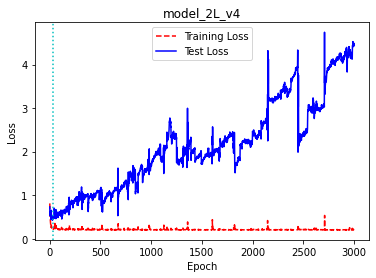

In [12]:
model = tf.keras.Sequential([      
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(3)
    ])
learning_rate = 0.01
batch_size = 32
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate)
metrics = ['accuracy']
model_filename = 'models/model_2L_v4'
model_l_v_e_filename = 'loss_vs_epochs_images/model_2L_v4_le.png'
model_l_v_e_title = 'model_2L_v4'
model_history_filename = 'history/history_model_2L_v4'

model.compile(optimizer, loss_fn, metrics)


checkpoint = ModelCheckpoint(model_filename, monitor='val_loss', verbose=1,save_best_only=True, mode='min')
model.fit(X_train, y_train, epochs = 3000,  validation_data=(X_test, y_test),batch_size = batch_size,callbacks=[checkpoint], verbose=2)
model.summary()
graph_loss_vs_epochs(model.history, model_l_v_e_filename, model_l_v_e_title)
save_history(model_history_filename, model)

In [13]:
best_m1_v4 = load_model(model_filename)
evaluate_model(best_m1_v4, X_test, y_test)


Evaluating:
7/7 [==============================] - 1s 2ms/step - loss: 0.4291 - accuracy: 0.8290

Test accuracy: 82.9%, test loss: 0.429146


In [16]:
output_filename_test_ds_labeled = 'test-ds-m2L_v4.csv'
fill_test_ds_labels(model, test_ds_filename, output_filename_test_ds_labeled)

241


##### Model_2 v5
    2 layers
    learning_rate = 0.005
    batch_size = 32
    optimizer: ADAM
    Dense units:  128, 128

Epoch 1/3000
25/25 - 2s - loss: 0.8410 - accuracy: 0.6096 - val_loss: 0.6646 - val_accuracy: 0.7047

Epoch 00001: val_loss improved from inf to 0.66459, saving model to models\model_2L_v5
INFO:tensorflow:Assets written to: models\model_2L_v5\assets
Epoch 2/3000
25/25 - 1s - loss: 0.6652 - accuracy: 0.7056 - val_loss: 0.6116 - val_accuracy: 0.7150

Epoch 00002: val_loss improved from 0.66459 to 0.61165, saving model to models\model_2L_v5
INFO:tensorflow:Assets written to: models\model_2L_v5\assets
Epoch 3/3000
25/25 - 0s - loss: 0.6031 - accuracy: 0.7471 - val_loss: 0.6044 - val_accuracy: 0.7306

Epoch 00003: val_loss improved from 0.61165 to 0.60436, saving model to models\model_2L_v5
INFO:tensorflow:Assets written to: models\model_2L_v5\assets
Epoch 4/3000
25/25 - 0s - loss: 0.5315 - accuracy: 0.7756 - val_loss: 0.5322 - val_accuracy: 0.7720

Epoch 00004: val_loss improved from 0.60436 to 0.53220, saving model to models\model_2L_v5
INFO:tensorflow:Assets written to: models\model_2L_v5

FileNotFoundError: [Errno 2] No such file or directory: 'loss_vs_epochs_images/model_2L_v5_le.png'

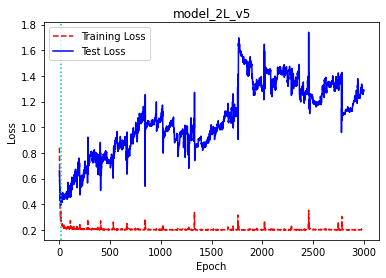

In [14]:
model = tf.keras.Sequential([      
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(3)
    ])
learning_rate = 0.005
batch_size = 32
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate)
metrics = ['accuracy']
model_filename = 'models/model_2L_v5'
model_l_v_e_filename = 'loss_vs_epochs_images/model_2L_v5_le.png'
model_l_v_e_title = 'model_2L_v5'
model_history_filename = 'history/history_model_2L_v5'

model.compile(optimizer, loss_fn, metrics)


checkpoint = ModelCheckpoint(model_filename, monitor='val_loss', verbose=1,save_best_only=True, mode='min')
model.fit(X_train, y_train, epochs = 3000,  validation_data=(X_test, y_test),batch_size = batch_size,callbacks=[checkpoint], verbose=2)
model.summary()
graph_loss_vs_epochs(model.history, model_l_v_e_filename, model_l_v_e_title)
save_history(model_history_filename, model)

In [15]:
best_m1_v5 = load_model(model_filename)
evaluate_model(best_m1_v5, X_test, y_test)


Evaluating:
7/7 [==============================] - 0s 2ms/step - loss: 0.3943 - accuracy: 0.8394

Test accuracy: 83.9%, test loss: 0.394312


In [17]:
output_filename_test_ds_labeled = 'test-ds-m2L_v5.csv'
fill_test_ds_labels(model, test_ds_filename, output_filename_test_ds_labeled)

241


##### Model_2 v6
    2 layers
    learning_rate = 0.001
    batch_size = 16
    optimizer: ADAM
    Dense units:  128, 192

Epoch 1/4000
49/49 - 2s - loss: 0.8571 - accuracy: 0.5824 - val_loss: 0.7363 - val_accuracy: 0.6995

Epoch 00001: val_loss improved from inf to 0.73633, saving model to models\model_2L_v6
INFO:tensorflow:Assets written to: models\model_2L_v6\assets
Epoch 2/4000
49/49 - 1s - loss: 0.7026 - accuracy: 0.7017 - val_loss: 0.6408 - val_accuracy: 0.7254

Epoch 00002: val_loss improved from 0.73633 to 0.64080, saving model to models\model_2L_v6
INFO:tensorflow:Assets written to: models\model_2L_v6\assets
Epoch 3/4000
49/49 - 0s - loss: 0.6171 - accuracy: 0.7341 - val_loss: 0.6215 - val_accuracy: 0.7202

Epoch 00003: val_loss improved from 0.64080 to 0.62148, saving model to models\model_2L_v6
INFO:tensorflow:Assets written to: models\model_2L_v6\assets
Epoch 4/4000
49/49 - 0s - loss: 0.5588 - accuracy: 0.7704 - val_loss: 0.5519 - val_accuracy: 0.7565

Epoch 00004: val_loss improved from 0.62148 to 0.55195, saving model to models\model_2L_v6
INFO:tensorflow:Assets written to: models\model_2L_v6

FileNotFoundError: [Errno 2] No such file or directory: 'loss_vs_epochs_images/model_2L_v6_le.png'

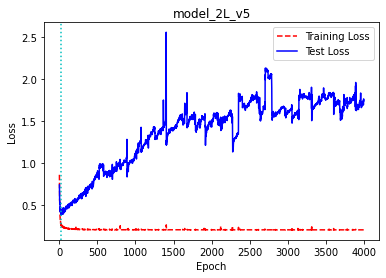

In [5]:
model = tf.keras.Sequential([      
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(192, activation='relu'),
      tf.keras.layers.Dense(3)
    ])
learning_rate = 0.001
batch_size = 16
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate)
metrics = ['accuracy']
model_filename = 'models/model_2L_v6'
model_l_v_e_filename = 'loss_vs_epochs_images/model_2L_v6_le.png'
model_l_v_e_title = 'model_2L_v6'
model_history_filename = 'history/history_model_2L_v6'

model.compile(optimizer, loss_fn, metrics)


checkpoint = ModelCheckpoint(model_filename, monitor='val_loss', verbose=1,save_best_only=True, mode='min')
model.fit(X_train, y_train, epochs = 4000,  validation_data=(X_test, y_test),batch_size = batch_size,callbacks=[checkpoint], verbose=2)
model.summary()
graph_loss_vs_epochs(model.history, model_l_v_e_filename, model_l_v_e_title)
save_history(model_history_filename, model)

In [6]:
best_m1_v6 = load_model(model_filename)
evaluate_model(best_m1_v6, X_test, y_test)


Evaluating:
7/7 [==============================] - 1s 3ms/step - loss: 0.3792 - accuracy: 0.8342

Test accuracy: 83.4%, test loss: 0.379153


In [8]:
test_ds_filename = '../test-ds.csv'
output_filename_test_ds_labeled = 'test-ds-m2L_v6.csv'
fill_test_ds_labels(model, test_ds_filename, output_filename_test_ds_labeled)

241


##### Model_2 v7
    2 layers
    learning_rate = 0.001
    batch_size = 32
    optimizer: ADAM
    Dense units:  64, 96

Epoch 1/3000
25/25 - 2s - loss: 0.9530 - accuracy: 0.5435 - val_loss: 0.8760 - val_accuracy: 0.6166

Epoch 00001: val_loss improved from inf to 0.87598, saving model to models\model_2L_v7
INFO:tensorflow:Assets written to: models\model_2L_v7\assets
Epoch 2/3000
25/25 - 0s - loss: 0.8214 - accuracy: 0.6265 - val_loss: 0.7975 - val_accuracy: 0.6528

Epoch 00002: val_loss improved from 0.87598 to 0.79746, saving model to models\model_2L_v7
INFO:tensorflow:Assets written to: models\model_2L_v7\assets
Epoch 3/3000
25/25 - 0s - loss: 0.7611 - accuracy: 0.6589 - val_loss: 0.7439 - val_accuracy: 0.6995

Epoch 00003: val_loss improved from 0.79746 to 0.74388, saving model to models\model_2L_v7
INFO:tensorflow:Assets written to: models\model_2L_v7\assets
Epoch 4/3000
25/25 - 0s - loss: 0.7117 - accuracy: 0.6952 - val_loss: 0.7143 - val_accuracy: 0.6995

Epoch 00004: val_loss improved from 0.74388 to 0.71433, saving model to models\model_2L_v7
INFO:tensorflow:Assets written to: models\model_2L_v7

FileNotFoundError: [Errno 2] No such file or directory: 'loss_vs_epochs_images/model_2L_v7_le.png'

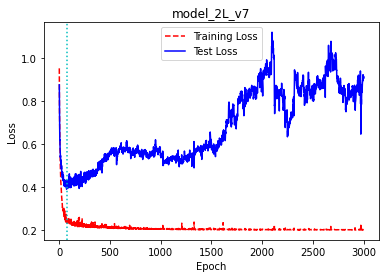

In [4]:
model = tf.keras.Sequential([      
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(96, activation='relu'),
      tf.keras.layers.Dense(3)
    ])
learning_rate = 0.001
batch_size = 32
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate)
metrics = ['accuracy']
model_filename = 'models/model_2L_v7'
model_l_v_e_filename = 'loss_vs_epochs_images/model_2L_v7_le.png'
model_l_v_e_title = 'model_2L_v7'
model_history_filename = 'history/history_model_2L_v7'

model.compile(optimizer, loss_fn, metrics)


checkpoint = ModelCheckpoint(model_filename, monitor='val_loss', verbose=1,save_best_only=True, mode='min')
model.fit(X_train, y_train, epochs = 3000,  validation_data=(X_test, y_test),batch_size = batch_size,callbacks=[checkpoint], verbose=2)
model.summary()
graph_loss_vs_epochs(model.history, model_l_v_e_filename, model_l_v_e_title)
save_history(model_history_filename, model)

In [5]:
best_m1_v7 = load_model(model_filename)
evaluate_model(best_m1_v7, X_test, y_test)


Evaluating:
7/7 [==============================] - 1s 3ms/step - loss: 0.3899 - accuracy: 0.8342

Test accuracy: 83.4%, test loss: 0.389896


In [7]:
test_ds_filename = '../test-ds.csv'
output_filename_test_ds_labeled = 'test-ds-m2L_v7.csv'
fill_test_ds_labels(model, test_ds_filename, output_filename_test_ds_labeled)

241


##### Model_2 v8
    2 layers
    learning_rate = 0.001
    batch_size = 32
    optimizer: ADAM
    Dense units:  32, 32

Epoch 1/3000
25/25 - 2s - loss: 1.0270 - accuracy: 0.4332 - val_loss: 0.9258 - val_accuracy: 0.4922

Epoch 00001: val_loss improved from inf to 0.92581, saving model to models\model_2L_v8
INFO:tensorflow:Assets written to: models\model_2L_v8\assets
Epoch 2/3000
25/25 - 0s - loss: 0.8876 - accuracy: 0.5629 - val_loss: 0.8532 - val_accuracy: 0.5959

Epoch 00002: val_loss improved from 0.92581 to 0.85322, saving model to models\model_2L_v8
INFO:tensorflow:Assets written to: models\model_2L_v8\assets
Epoch 3/3000
25/25 - 0s - loss: 0.8318 - accuracy: 0.6122 - val_loss: 0.8107 - val_accuracy: 0.6736

Epoch 00003: val_loss improved from 0.85322 to 0.81073, saving model to models\model_2L_v8
INFO:tensorflow:Assets written to: models\model_2L_v8\assets
Epoch 4/3000
25/25 - 0s - loss: 0.7942 - accuracy: 0.6304 - val_loss: 0.7734 - val_accuracy: 0.7047

Epoch 00004: val_loss improved from 0.81073 to 0.77343, saving model to models\model_2L_v8
INFO:tensorflow:Assets written to: models\model_2L_v8

FileNotFoundError: [Errno 2] No such file or directory: 'loss_vs_epochs_images/model_2L_v8_le.png'

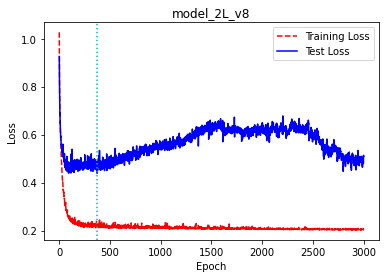

In [8]:
model = tf.keras.Sequential([      
      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dense(3)
    ])
learning_rate = 0.001
batch_size = 32
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate)
metrics = ['accuracy']
model_filename = 'models/model_2L_v8'
model_l_v_e_filename = 'loss_vs_epochs_images/model_2L_v8_le.png'
model_l_v_e_title = 'model_2L_v8'
model_history_filename = 'history/history_model_2L_v8'

model.compile(optimizer, loss_fn, metrics)


checkpoint = ModelCheckpoint(model_filename, monitor='val_loss', verbose=1,save_best_only=True, mode='min')
model.fit(X_train, y_train, epochs = 3000,  validation_data=(X_test, y_test),batch_size = batch_size,callbacks=[checkpoint], verbose=2)
model.summary()
graph_loss_vs_epochs(model.history, model_l_v_e_filename, model_l_v_e_title)
save_history(model_history_filename, model)

In [9]:
best_m1_v8 = load_model(model_filename)
evaluate_model(best_m1_v8, X_test, y_test)


Evaluating:
7/7 [==============================] - 0s 2ms/step - loss: 0.4390 - accuracy: 0.8394

Test accuracy: 83.9%, test loss: 0.438977


In [10]:
test_ds_filename = '../test-ds.csv'
output_filename_test_ds_labeled = 'test-ds-m2L_v8.csv'
fill_test_ds_labels(model, test_ds_filename, output_filename_test_ds_labeled)

241


##### Model_2 v9
    2 layers
    learning_rate = 0.001
    batch_size = 32
    optimizer: ADAM
    Dense units:  32, 32
    activation= sigmoid

Epoch 1/3000
25/25 - 2s - loss: 1.0042 - accuracy: 0.5032 - val_loss: 0.9262 - val_accuracy: 0.5648

Epoch 00001: val_loss improved from inf to 0.92621, saving model to models\model_2L_v9
INFO:tensorflow:Assets written to: models\model_2L_v9\assets
Epoch 2/3000
25/25 - 0s - loss: 0.9229 - accuracy: 0.5305 - val_loss: 0.9198 - val_accuracy: 0.6062

Epoch 00002: val_loss improved from 0.92621 to 0.91977, saving model to models\model_2L_v9
INFO:tensorflow:Assets written to: models\model_2L_v9\assets
Epoch 3/3000
25/25 - 0s - loss: 0.9153 - accuracy: 0.5266 - val_loss: 0.9050 - val_accuracy: 0.5648

Epoch 00003: val_loss improved from 0.91977 to 0.90498, saving model to models\model_2L_v9
INFO:tensorflow:Assets written to: models\model_2L_v9\assets
Epoch 4/3000
25/25 - 0s - loss: 0.9080 - accuracy: 0.5694 - val_loss: 0.9016 - val_accuracy: 0.6010

Epoch 00004: val_loss improved from 0.90498 to 0.90157, saving model to models\model_2L_v9
INFO:tensorflow:Assets written to: models\model_2L_v9

FileNotFoundError: [Errno 2] No such file or directory: 'loss_vs_epochs_images/model_2L_v9_le.png'

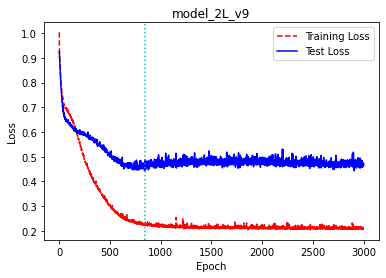

In [16]:
model = tf.keras.Sequential([      
      tf.keras.layers.Dense(32, activation='sigmoid'),
      tf.keras.layers.Dense(32, activation='sigmoid'),
      tf.keras.layers.Dense(3)
    ])
learning_rate = 0.001
batch_size = 32
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate)
metrics = ['accuracy']
model_filename = 'models/model_2L_v9'
model_l_v_e_filename = 'loss_vs_epochs_images/model_2L_v9_le.png'
model_l_v_e_title = 'model_2L_v9'
model_history_filename = 'history/history_model_2L_v9'

model.compile(optimizer, loss_fn, metrics)


checkpoint = ModelCheckpoint(model_filename, monitor='val_loss', verbose=1,save_best_only=True, mode='min')
model.fit(X_train, y_train, epochs = 3000,  validation_data=(X_test, y_test),batch_size = batch_size,callbacks=[checkpoint], verbose=2)
model.summary()
graph_loss_vs_epochs(model.history, model_l_v_e_filename, model_l_v_e_title)
save_history(model_history_filename, model)

In [19]:
best_m1_v9 = load_model(model_filename)
evaluate_model(best_m1_v9, X_test, y_test)


Evaluating:
7/7 [==============================] - 0s 3ms/step - loss: 0.4425 - accuracy: 0.8238

Test accuracy: 82.4%, test loss: 0.442497


In [20]:
test_ds_filename = '../test-ds.csv'
output_filename_test_ds_labeled = 'test-ds-m2L_v9.csv'
fill_test_ds_labels(model, test_ds_filename, output_filename_test_ds_labeled)

241
